# ITKVkFFT Python Demonstration

This example demonstrates accelerated image blurring in ITK with VkFFT.

Gaussian blurring of an N-dimensional image is typically accomplished via image convolution.
ITK defines two mechanisms for convolution with a Gaussian kernel:
- Perform separable convolution, where the image filter performs one pass over the image
  in each direction with a dimension-dependent 1D convolution kernel. This is the default behavior
  defined by `DiscreteGaussianImageFilter`.
- Multiply the Fourier transforms of both the ND image and the ND convolution kernel,
  then transform back into the physical domain. This is the default behavior defined by
  `FFTDiscreteGaussianImageFilter`.
  
Accelerated FFT computation offers speedup benefits for Fourier-domain convolution. We can register
a factory override with `FFTDiscreteGaussianImageFilterFactory` so that any ITK image filter making
use of `DiscreteGaussianImageFilter` internally will default to the FFT GPU-accelerated filter instead.

In [1]:
import sys
!{sys.executable} -m pip install itk-vkfft matplotlib


In [2]:
import os
import time
from urllib.request import urlretrieve

import itk
import numpy as np
import matplotlib.pyplot as plt

img_args = {"aspect": "auto", "interpolation": "none", "origin": "lower"}

# Verify that ITKVkFFTBackend is installed
assert "VkForwardFFTImageFilter" in dir(itk)


## Compare Separable vs FFT Blurring Applied to Downsampled MRI Volume

Here we perform Gaussian blurring on a small MRI 3D volume.

We compare performance between default separable convolution, which runs on CPU, and 
Fourier convolution with the accelerated `vkfft` backend, which runs on CPU or GPU via OpenCL. 

For small datasets like this, running FFT on the CPU is typically more efficient than the added overhead of generating a GPU schedule with `vkfft`.

In [3]:
# Retrieve image for demo

IMAGE_PATH = "data/HeadMRVolume.mha"

if not os.path.exists(IMAGE_PATH):
    os.makedirs("data", exist_ok=True)
    url = "https://data.kitware.com/api/v1/file/5cad1a368d777f072b180d63/download"
    urlretrieve(url, IMAGE_PATH)


Retrieved image of size itkSize3 ([48, 62, 42])


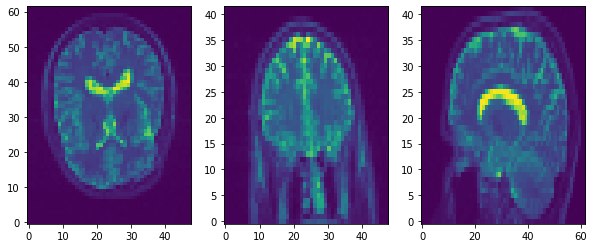

In [4]:
mri_image = itk.imread(IMAGE_PATH, pixel_type=itk.F)
print(f"Retrieved image of size {itk.size(mri_image)}")

# Visualize a slice in each dimension
_, axs = plt.subplots(ncols=3, figsize=(10, 4))

axs[0].imshow(mri_image[20, :, :], **img_args)
axs[1].imshow(mri_image[:, 20, :], **img_args)
axs[2].imshow(mri_image[:, :, 20], **img_args)

plt.show()


In [5]:
blur_args = {"variance": 25.0, "maximum_error": 1e-3, "maximum_kernel_width": 25}


Separable blurring completed in 3.662 s


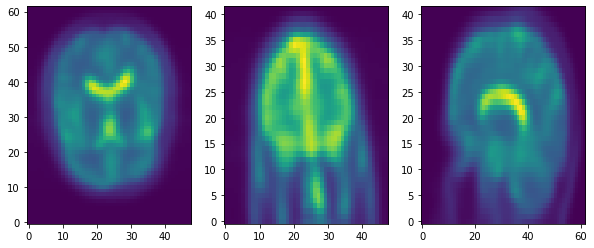

In [6]:
# Gaussian Blurring
tstart = time.time()
separable_blurred_image = itk.discrete_gaussian_image_filter(mri_image, **blur_args)
tend = time.time()
print(f"Separable blurring completed in {(tend - tstart):0.3f} s")

_, axs = plt.subplots(ncols=3, figsize=(10, 4))

axs[0].imshow(separable_blurred_image[20, :, :], **img_args)
axs[1].imshow(separable_blurred_image[:, 20, :], **img_args)
axs[2].imshow(separable_blurred_image[:, :, 20], **img_args)

plt.show()


VkFFT blurring completed in 1.385 s


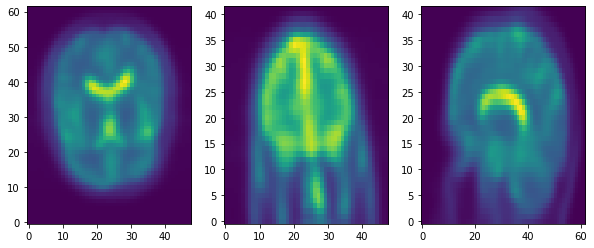

In [7]:
# Blurring by FFT Convolution
tstart = time.time()
fourier_blurred_image = itk.fft_discrete_gaussian_image_filter(mri_image, **blur_args)
tend = time.time()
print(f"VkFFT blurring completed in {(tend - tstart):0.3f} s")

_, axs = plt.subplots(ncols=3, figsize=(10, 4))

axs[0].imshow(fourier_blurred_image[20, :, :], **img_args)
axs[1].imshow(fourier_blurred_image[:, 20, :], **img_args)
axs[2].imshow(fourier_blurred_image[:, :, 20], **img_args)

plt.show()


## Blur a Large, Random Volume

Here we compare Gaussian blurring performance on a large, random 3D volume. For larger datasets like this GPU acceleration with `vkfft` typically yields significant speedup.

In [8]:
rand_image = itk.image_from_array(np.random.rand(500, 500, 500).astype(np.float32))


Vnl blurring completed in 12.652 s


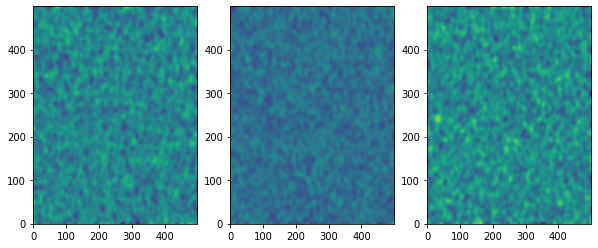

In [9]:
# Gaussian Blurring
tstart = time.time()
separable_blurred_image = itk.discrete_gaussian_image_filter(rand_image, **blur_args)
tend = time.time()
print(f"Vnl blurring completed in {(tend - tstart):0.3f} s")

_, axs = plt.subplots(ncols=3, figsize=(10, 4))

axs[0].imshow(separable_blurred_image[20, :, :], **img_args)
axs[1].imshow(separable_blurred_image[:, 20, :], **img_args)
axs[2].imshow(separable_blurred_image[:, :, 20], **img_args)

plt.show()


Vk blurring completed in 6.204 s


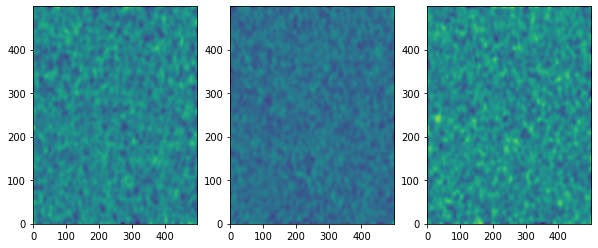

In [10]:
# Blurring by FFT Convolution
tstart = time.time()
fourier_blurred_image = itk.fft_discrete_gaussian_image_filter(rand_image, **blur_args)
tend = time.time()
print(f"Vk blurring completed in {(tend - tstart):0.3f} s")

_, axs = plt.subplots(ncols=3, figsize=(10, 4))

axs[0].imshow(fourier_blurred_image[20, :, :], **img_args)
axs[1].imshow(fourier_blurred_image[:, 20, :], **img_args)
axs[2].imshow(fourier_blurred_image[:, :, 20], **img_args)

plt.show()
